In [1]:
from data_reader import LMDBReader, CCPDHelper

# your path to data
train_path = r'../../CCPD/CCPD/train.lmdb'
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = CCPDHelper(train_reader)
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = CCPDHelper(train_reader)
names = train_reader.namelist()
SEED = 42
TRAIN_PART = 0.8
rng = np.random.default_rng(SEED)
permutation = rng.permutation(len(names))
train_size = int(len(names) * 0.8)
train_names = [names[i] for i in permutation[:train_size]]
val_names = [names[i] for i in permutation[train_size:]]
train_helper = CCPDHelper(train_reader, train_names)
val_helper = CCPDHelper(train_reader, val_names)
img0, txt0 = train_helper.item(0)

In [2]:
pred_path = './valgt.txt'
with open(pred_path, 'w', encoding='utf-8') as out:
    for i in range(val_helper.size()):
        img, gt = val_helper.item(i) # it will be 0 points if you will use gtruth from test database
        print(i, gt, file=out)

In [3]:
from tqdm import tqdm
from collections import Counter

# counters = [set() for _ in range(7)]
# for i in tqdm(range(train_helper.size())):
#     _, gtruth = train_helper.item(i)
#     # print(len(gtruth))
#     for place, c in enumerate(gtruth):
#         counters[place].update(c)
#     # if i > 10:
#     #     break
# for j in range(len(counters)):
#     counters[j] = sorted(list(counters[j]))

In [4]:
iers = ['云', '京', '冀', '吉', '宁', '川', '新', '晋', '桂', '沪', '津', '浙', '渝', '湘', '琼', '甘', '皖', '粤', '苏', '蒙', '藏', '豫', '贵', '赣', '辽', '鄂', '闽', '陕', '青', '鲁', '黑']
nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
lets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

counters = [iers, lets] +  [nums+lets] * 5

In [5]:
def str2ids(gt):
    ids = []
    for i, c in enumerate(gt):
        if c in counters[i]:
            ids.append(counters[i].index(c))
        else:
            ids.append(0)
    return ids
i = 0
_, gtruth = train_helper.item(i)
gtruth, str2ids(gtruth)

('皖A5A454', [16, 0, 5, 10, 4, 5, 4])

In [6]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import albumentations as A

class MyDataset(Dataset):
    def __init__(self, split, aug=None, rotation=None):
        self.split = split
        self.transform = transform
        self.aug = aug
        self.rotation = rotation
    def __getitem__(self, i):
        img, gtruth = self.split.item(i)
        img = np.array(img).astype(np.uint8)
        if self.aug is not None:
            res = aug_big(image=img)
            img = res['image']

        gtruth = torch.tensor(str2ids(gtruth))
        img = torch.tensor(img).permute(2, 0, 1)
        return img, gtruth
    def __len__(self):
        return self.split.size()
    

image_size=172
batch_size=16

transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
])
test_transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

aprob = 0.08
aug_big = A.Compose([
    A.SmallestMaxSize(image_size, always_apply=True),
    A.ColorJitter(p=aprob),
    A.Downscale(scale_min=0.5, scale_max=0.8, p=aprob),
    A.AdvancedBlur (blur_limit=(3, 5), sigmaX_limit=(0.9, 1.0), sigmaY_limit=(0.9, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1), p=aprob), 
    A.GaussNoise(p=aprob),
    A.HueSaturationValue(p=aprob),
    A.MultiplicativeNoise(p=aprob),
    A.PixelDropout(p=aprob),
    A.RandomBrightnessContrast(p=aprob),
    A.RandomFog(p=aprob),
    A.RandomRain(p=aprob),
    A.ISONoise(color_shift=(0.03, 0.09), p=aprob),
    A.RandomShadow(p=aprob),
    A.RandomToneCurve(scale=0.01,p=aprob),
    A.MotionBlur (blur_limit=5, p=aprob),
    A.RandomSnow(p=aprob),
    A.RandomSunFlare(src_radius=150,p=aprob),
    A.Spatter(intensity=0.2, p=aprob),
    A.OneOf([
        A.dropout.coarse_dropout.CoarseDropout(max_holes=4, max_height=25, max_width=25, p=aprob, fill_value=100),
        A.dropout.coarse_dropout.CoarseDropout(max_holes=12, max_height=10, max_width=10, p=aprob, fill_value=100),
        A.dropout.coarse_dropout.CoarseDropout(max_holes=2, max_height=40, max_width=40, p=aprob, fill_value=100),
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)
]
)

aug_test = A.Compose([
    A.SmallestMaxSize(image_size, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255, always_apply=True)
]
)
import kornia.geometry.transform as GT
def rotation(img, coords, w, h):    
    img = torch.tensor(img).permute(2, 0, 1)
    alpha = np.random.uniform(-25, 25)
    dsize = torch.tensor([w, h])
    center = torch.tensor([[h/2, w/2]])
    mat = GT.get_rotation_matrix2d(center, torch.ones(1) * alpha, torch.ones(1, 2))
    img = GT.warp_affine(img.unsqueeze(0), mat, dsize, padding_mode='reflection').squeeze()
    coords = (mat.squeeze()[:2, :2] @ (coords - center).T.float() ).T + center
    return img, coords

trainset = MyDataset(train_helper, aug_big, True)
valset = MyDataset(val_helper, aug_test)
testset = MyDataset(test_helper, aug_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1693: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  "Using default interpolation INTER_NEAREST, which is sub-optimal."


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationModel(nn.Module):
    def __init__(self, model, symbs, hidden_size):
        super(ClassificationModel, self).__init__()
        self.model = model
        self.symbs = symbs
        self.cls = nn.Linear(hidden_size, sum([len(c) for c in self.symbs]))
    def forward(self, x):
        x = self.model(x)
        preds = self.cls(x)
        return preds

In [8]:
from torchvision.models import efficientnet_b5
from torchvision.models import efficientnet_b2
from torch import nn

device = 'cuda'
bb = efficientnet_b5(weights='DEFAULT')
bb.classifier[1] = nn.Identity()
hidden_size = 2048
model = ClassificationModel(bb, counters, hidden_size)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
# loss_fn = nn.L1Loss(reduction='sum')
loss_fn = nn.CrossEntropyLoss()
epochs = 1
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
losses_train = []
losses_test = []
MAXACC = 0
coeff = 1
noise=0.

In [9]:
idxs_slice = [0]
for c in counters:
    idxs_slice.append(idxs_slice[-1] + len(c))
idxs_slice

[0, 31, 55, 89, 123, 157, 191, 225]

loss train 0.045349183522744745
acc 99.77821428571428 99.77821428571428


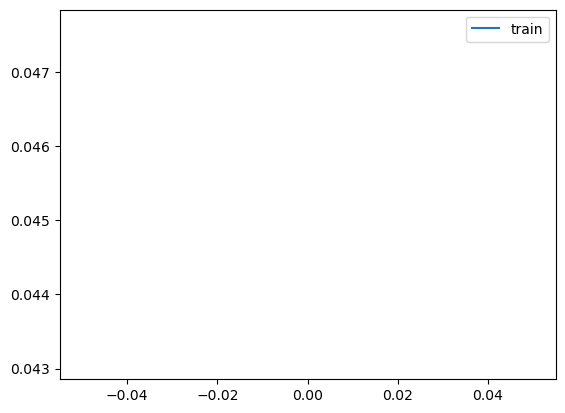

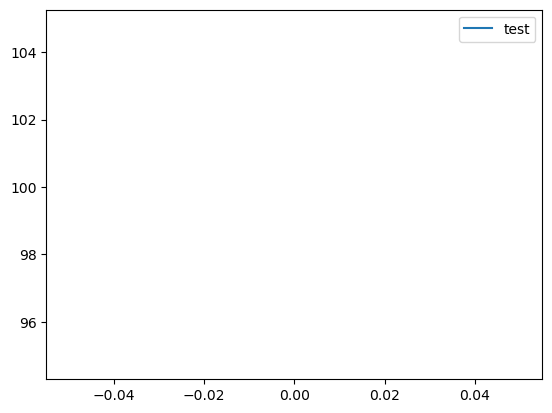

In [10]:
from course_ocr_t2.evaluate import evaluate

for i in range(epochs):
    loss_train = 0
    
#     loss_test = 0
#     acc_test = 0
    model.train()
    
    for x, y in tqdm(trainloader):
#         with torch.autocast(device_type='cuda', dtype=torch.float16):
        pred = model(x.to(device))
        loss = 0
        
        for j in range(len(counters)):
            i1 = idxs_slice[j]
            i2 = idxs_slice[j + 1]
#             print(i1, i2, j)
            loss += loss_fn(pred[:, i1:i2], y[:, j].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        loss_train += loss.item()
    scheduler.step()
    
    model.eval()
    losses_train.append(loss_train / len(trainset))

    with torch.no_grad():
        
        pred_path = './valpred.txt'
        with open(pred_path, 'w', encoding='utf-8') as out:
            for i in range(val_helper.size()):
                img, _ = valset[i]
                pred = model(img.unsqueeze(0).to(device))
                stri = []
                for j in range(len(counters)):
                    i1 = idxs_slice[j]
                    i2 = idxs_slice[j + 1]
                    stri.append(counters[j][pred[0, i1:i2].argmax().item()])
                stri = ''.join(stri)
                print(i, stri, file=out)
        acc = evaluate('./valgt.txt', './valpred.txt') * 100
        losses_test.append(acc)
    
    if acc > MAXACC:
        MAXACC = acc
        torch.save(model.state_dict(), '../../cls.pkl')
        
    
    clear_output()
    print('loss train', losses_train[-1])#, 'pred_ep_test', pred_ep_test.item() / len(testset))
    print('acc', acc, MAXACC)
#     noise = min(0.1 * pred_ep_train.item() / len(trainset), 1)
    plt.plot(losses_train, label='train')
    plt.legend()
    plt.show()
    
    plt.plot(losses_test, label='test')
    plt.legend()
    plt.show()

In [12]:
test_path = r'../../CCPD/CCPD/test.lmdb'
pred_path = './pred.txt'

In [ ]:
with open(pred_path, 'w', encoding='utf-8') as out:
    with LMDBReader(test_path) as test_reader:
        helper = CCPDHelper(test_reader)
        testset = MyDataset(helper, aug_test)
        for i in tqdm(range(helper.size())):
            img, _ = testset[i]
            pred = model(img.unsqueeze(0).to(device))
            stri = []
            for j in range(len(counters)):
                i1 = idxs_slice[j]
                i2 = idxs_slice[j + 1]
                stri.append(counters[j][pred[0, i1:i2].argmax().item()])
            stri = ''.join(stri)
            print(i, stri, file=out)

 92%|███████████████████████████████████████████████████████████████████████████████████████████▎       | 18496/20052 [10:17<00:51, 30.40it/s]

In [ ]:
evaluate('./gt.txt', './pred.txt') * 100